In [1]:
import os
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir('gdrive/MyDrive/boddam-masters-project')

Mounted at /content/gdrive


In [2]:
!sudo apt-get install openslide-tools
!sudo apt-get install python-openslide
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 5 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 1s (71.7 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf

In [3]:
!pip install pyclesperanto-prototype

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 585 kB 26.0 MB/s 
     |████████████████████████████████| 934 kB 41.7 MB/s 
     |████████████████████████████████| 1.4 MB 57.7 MB/s 
     |████████████████████████████████| 70 kB 8.7 MB/s 
  Created wheel for pytools: filename=pytools-2022.1.12-py2.py3-none-any.whl size=65033 sha256=73d2bfdaad8fdb934b468c1add4ea3a8da1645a0a9fcd5eaca6346a06bdd7d8a
  Stored in directory: /root/.cache/pip/wheels/37/5e/9e/76d7430e116b7cab0016fbabb26b896daae1946a3f7dea9915
  Created wheel for transforms3d: filename=transforms3d-0.4.1-py3-none-any.whl size=1376772 sha256=ae92cbe63476ba5df1f8173ddb2ebea66c84613915295babe128de7b45b2d3bf
  Stored in directory: /root/.cache/pip/wheels/cc/da/f5/b05c90f16d37764a65c010013110b15eab345f9c310d1bc16f
Successfully built pytools transforms3d


In [4]:
from keras.utils import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

import pandas as pd
from PIL import Image
import glob
import numpy as np
from numpy import load, asarray, savez_compressed

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, io, img_as_ubyte
from skimage.color import rgb2hed, hed2rgb
from skimage.exposure import rescale_intensity

In [6]:
from openslide import ImageSlide, open_slide
import pyclesperanto_prototype as cle

In [7]:
data_width, data_height = 1000, 1000
tile_size = 256
path_normal = "data/train/normal/normal1.svs"
path_normal_2 = "data/train/normal/analysis.jpg"
path_tumor = "data/train/tumor/tumor1.svs"
path_tumor_2 = "data/train/tumor/analysis.jpg"

In [8]:
def color_separate(ihc_rgb):
    ihc_hed = rgb2hed(ihc_rgb)
    null = np.zeros_like(ihc_hed[:, :, 0])
    ihc_h = img_as_ubyte(hed2rgb(np.stack((ihc_hed[:, :, 0], null, null), axis=-1)))
    ihc_e = img_as_ubyte(hed2rgb(np.stack((null, ihc_hed[:, :, 1], null), axis=-1)))
    ihc_d = img_as_ubyte(hed2rgb(np.stack((null, null, ihc_hed[:, :, 2]), axis=-1)))
    h = rescale_intensity(ihc_hed[:, :, 0], out_range=(0, 1),
                          in_range=(0, np.percentile(ihc_hed[:, :, 0], 99)))
    d = rescale_intensity(ihc_hed[:, :, 2], out_range=(0, 1),
                          in_range=(0, np.percentile(ihc_hed[:, :, 2], 99)))

    zdh = img_as_ubyte(np.dstack((null, d, h)))

    return (ihc_h, ihc_e, ihc_d, zdh)

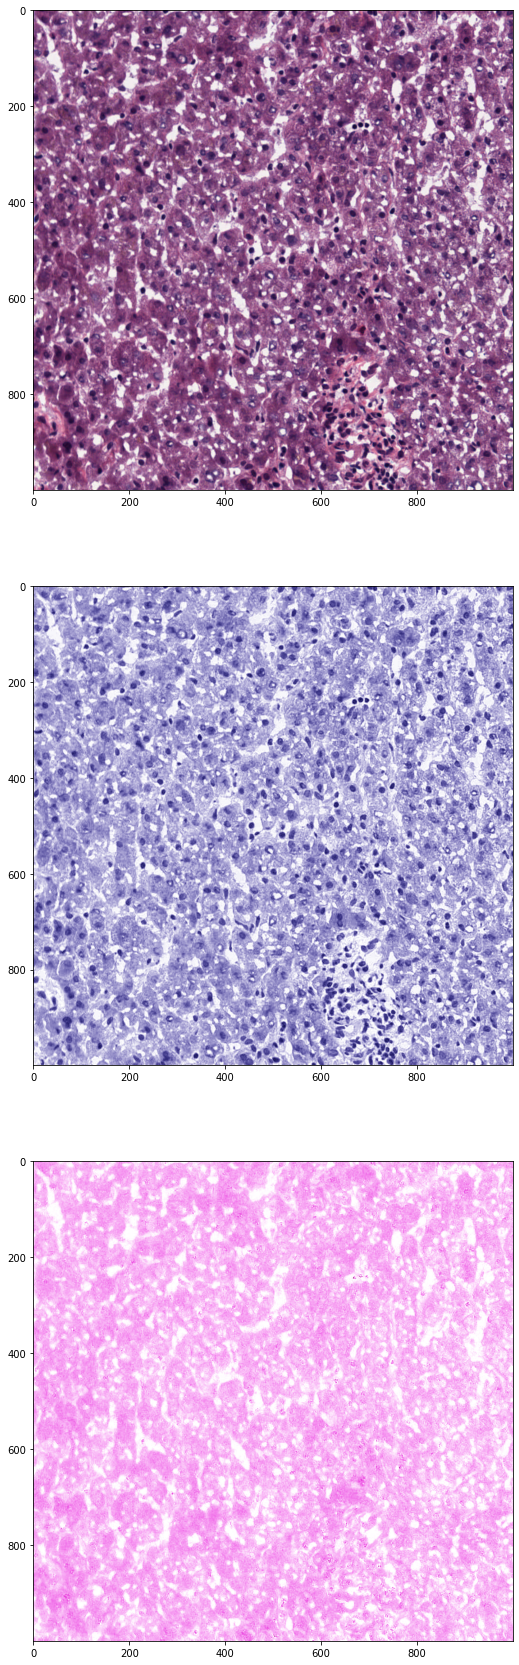

In [17]:
im = open_slide(path_normal)
imgwidth, imgheight = im.level_dimensions[0]
start_h = 3000
start_w = 8000
piece = im.read_region((start_w, start_h), 0, (data_width, data_height))
ihc_rgb = Image.new("RGB", (data_width, data_height), tile_size)
ihc_rgb.paste(piece)

fig, plot = plt.subplots(3, figsize=(30,30), 
                         gridspec_kw={'height_ratios': [1, 1, 1]})
plot[0].imshow(ihc_rgb)

H,E,D,HD = color_separate(ihc_rgb)

analysis = Image.new("RGB", (data_width, data_height))
analysis.save(path_normal_2)

plt.imsave(path_normal_2, H)
plot[1].imshow(H)
plot[2].imshow(E)

Used GPU:  <Tesla T4 on Platform: NVIDIA CUDA (2 refs)>


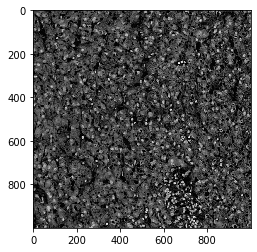

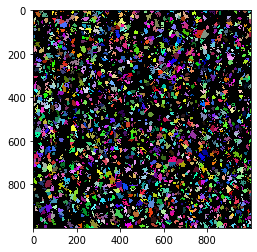

number of nuclie segments:  1976


In [28]:
device = cle.select_device()
print("Used GPU: ", device)

input_image = np.invert(H[:,:,2])
plt.imshow(input_image, cmap='gray')
input_gpu = cle.push(input_image)

cle.imshow(input_gpu)
    
sigma_spot_detection = 3
sigma_outline = 1

segmented = cle.voronoi_otsu_labeling(input_gpu, spot_sigma=sigma_spot_detection, 
                                      outline_sigma=sigma_outline)

cle.imshow(segmented, labels=True)

statistics = cle.statistics_of_labelled_pixels(input_gpu, segmented) 

table = pd.DataFrame(statistics)    

print("number of nuclie segments: ", len(table))


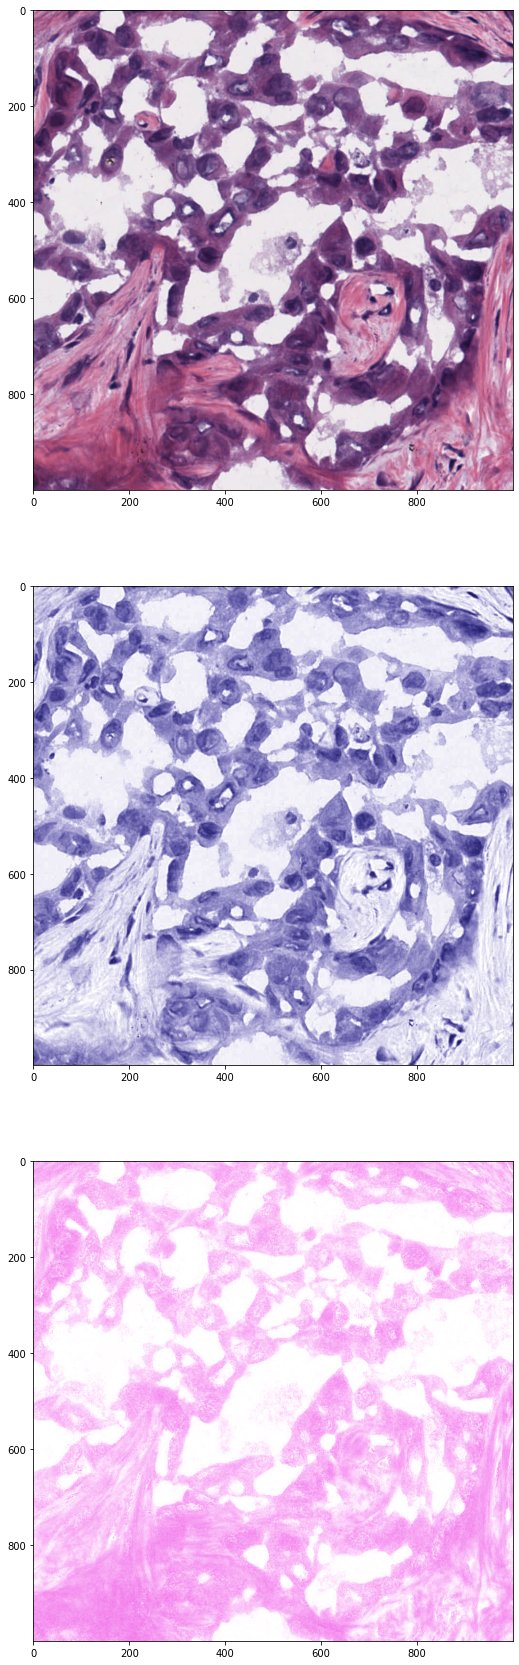

In [29]:
im = open_slide(path_tumor)
imgwidth, imgheight = im.level_dimensions[0]
start_h = 10000
start_w = 5000
piece = im.read_region((start_w, start_h), 0, (data_width, data_height))
ihc_rgb = Image.new("RGB", (data_width, data_height), tile_size)
ihc_rgb.paste(piece)

fig, plot = plt.subplots(3, figsize=(30,30), 
                         gridspec_kw={'height_ratios': [1, 1, 1]})
plot[0].imshow(ihc_rgb)

H,E,D,HD = color_separate(ihc_rgb)

analysis = Image.new("RGB", (data_width, data_height))
analysis.save(path_tumor_2)

plt.imsave(path_tumor_2, H)
plot[1].imshow(H)
plot[2].imshow(E)

Used GPU:  <Tesla T4 on Platform: NVIDIA CUDA (2 refs)>


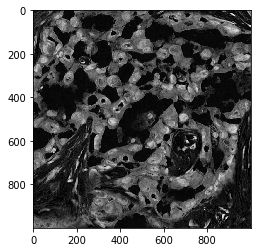

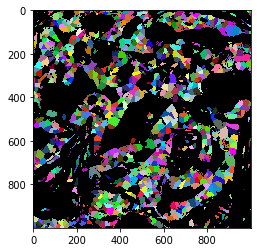

1097


In [30]:
device = cle.select_device()
print("Used GPU: ", device)

input_image = np.invert(H[:,:,2])
plt.imshow(input_image, cmap='gray')
input_gpu = cle.push(input_image)

cle.imshow(input_gpu)
    
sigma_spot_detection = 3
sigma_outline = 1

segmented = cle.voronoi_otsu_labeling(input_gpu, spot_sigma=sigma_spot_detection, 
                                      outline_sigma=sigma_outline)

cle.imshow(segmented, labels=True)

statistics = cle.statistics_of_labelled_pixels(input_gpu, segmented) 

table = pd.DataFrame(statistics)    

print(len(table))
